In [1]:
import cv2
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
from transformers import CLIPProcessor, CLIPModel



/home/tim/miniforge3/envs/data_Challenges/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:


# --- Load CLIP Model (Hugging Face) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("breezedeus/coin-clip-vit-base-patch32", use_safetensors=True).to(device)


processor = CLIPProcessor.from_pretrained("breezedeus/coin-clip-vit-base-patch32")

# --- Load and preprocess images ---
image_input_paths = glob.glob("../bueschelquinare_preprocessed/obverse/A/*.png")
featuBes = []

labels = []

for path in image_input_paths:
    try:
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)

        features.append(image_features.cpu().numpy()[0])
        labels.append(os.path.basename(os.path.dirname(path)))
    except Exception as e:
        print(f"Skipping {path}: {e}")

feature_vector = np.array(features)




Skipping ../bueschelquinare_preprocessed/obverse/A/2466_a_cropped_graymasked.png: 'numpy.ndarray' object has no attribute 'append'
Skipping ../bueschelquinare_preprocessed/obverse/A/2441_a_cropped_graymasked.png: 'numpy.ndarray' object has no attribute 'append'
Skipping ../bueschelquinare_preprocessed/obverse/A/3681_a_cropped_graymasked.png: 'numpy.ndarray' object has no attribute 'append'
Skipping ../bueschelquinare_preprocessed/obverse/A/3840_a_cropped_graymasked.png: 'numpy.ndarray' object has no attribute 'append'
Skipping ../bueschelquinare_preprocessed/obverse/A/3003_a_cropped_graymasked.png: 'numpy.ndarray' object has no attribute 'append'
Skipping ../bueschelquinare_preprocessed/obverse/A/3593_a_cropped_graymasked.png: 'numpy.ndarray' object has no attribute 'append'
Skipping ../bueschelquinare_preprocessed/obverse/A/3749_a_cropped_graymasked.png: 'numpy.ndarray' object has no attribute 'append'
Skipping ../bueschelquinare_preprocessed/obverse/A/2797_a_cropped_graymasked.png: '

In [3]:

print(torch.__version__)


2.7.0


In [4]:
from skimage.feature import hog
from skimage import color
import cv2
image_input_path = glob.glob("../bueschelquinare_preprocessed/obverse/*/*.png")
feature_vector = []
labels = []
for path in image_input_path:
# Bild laden und in Graustufen umwandeln
    image = cv2.imread(path)
    gray_image = color.rgb2gray(image)
    
    # HOG-Features extrahieren
    features, hog_image = hog(gray_image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True)
    feature_vector.append(features)
    label = os.path.basename(os.path.dirname(path))
    labels.append(label)


In [17]:
from skimage.feature import hog
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image and resize
image = cv2.imread('../bueschelquinare_preprocessed/obverse/A/260_a_cropped_graymasked.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 64))

# Compute HOG with feature_vector=False to get raw blocks
hog_feats = hog(image,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=False,
                feature_vector=False)

print("HOG feature raw shape:", hog_feats.shape)  
# Output example: (7, 15, 2, 2, 9) -> blocks_y, blocks_x, cells_per_block_y, cells_per_block_x, orientations

# Flatten to feature vector
hog_vector = hog_feats.ravel()
print("HOG vector length:", len(hog_vector))

# Let's say you have an SVM weight vector with the same length (for example):
# For demo, create dummy weights (same length as hog_vector)
weights = np.random.randn(len(hog_vector))

# Reshape weights to hog_feats shape (excluding last two dims for cells in block)
weights_reshaped = weights.reshape(hog_feats.shape)

# Now to visualize, average over cells_per_block and orientations to get a 2D map
weights_2d = weights_reshaped.mean(axis=(2, 3, 4))

plt.imshow(weights_2d, cmap='seismic')
plt.colorbar()
plt.title("SVM weights averaged over cells and orientations")
plt.show()


HOG feature raw shape: (7, 15, 2, 2, 9)
HOG vector length: 3780


In [3]:
# Step 5: Load a sample dataset (e.g. digits for simplicity)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array(X[:1000])
y = np.array(y[:1000])

# Resize and HOG each digit image
def preprocess(img_flat):
    img = img_flat.reshape(28, 28)
    fd = hog(img, block_norm='L2-Hys')
    return fd

X_hog = np.array([preprocess(x) for x in X])
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2)

# Step 6: Train Linear SVM
clf = LinearSVC()
clf.fit(X_train, y_train)

# Step 7: Visualize Weights for One Class (e.g. digit '0')
class_idx = 0  # index for class '0'
weights = clf.coef_[class_idx]
weights_reshaped = weights.reshape(hog_feats.shape)  # reshape based on HOG dimensions

plt.imshow(weights_image, cmap='seismic')
plt.title("SVM-weighted HOG Importance for Digit '0'")
plt.colorbar()
plt.show()


NameError: name 'fetch_openml' is not defined

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
features = np.array(feature_vector)
#normalisze
scaler = StandardScaler()
feature_vector = scaler.fit_transform(features)
#PCA
pca = PCA(n_components = 100)
reduced = pca.fit_transform(feature_vector)
# 4. t-SNE dimensionality reduction
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=20, max_iter=5000,init="pca")
X_tsne = tsne.fit_transform(reduced)
labels = labels[:X_tsne.shape[0]]
print("Finished")


Running t-SNE...
Finished


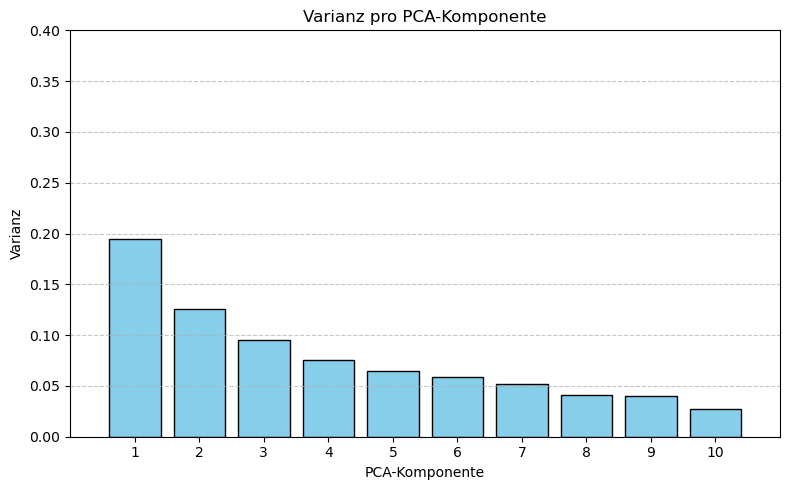

In [11]:
# Erklärte Varianzanteile extrahieren
explained_variance = pca.explained_variance_ratio_
#print(explained_variance)
# Balkendiagramm erstellen
plt.figure(figsize=(8, 5))
components = np.arange(1, 11)
plt.bar(components, explained_variance[:10], color='skyblue', edgecolor='black')
plt.xlabel('PCA-Komponente')
plt.ylabel('Varianz')
plt.xlim(0,11)
plt.title('Varianz pro PCA-Komponente')
plt.xticks(components)
plt.ylim(0, 0.4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Variance PCA.png")
plt.show()

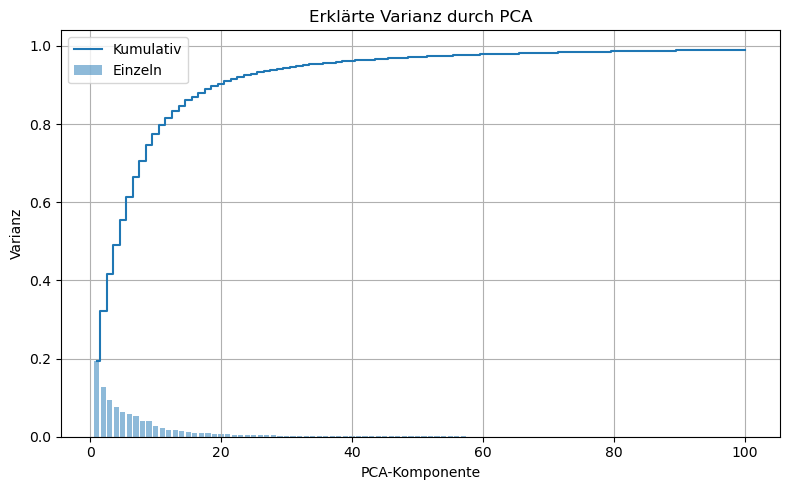

In [12]:


var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center', label='Einzeln')
plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where='mid', label='Kumulativ')
plt.ylabel('Varianz')
plt.xlabel('PCA-Komponente')
plt.legend(loc='best')
plt.title('Erklärte Varianz durch PCA')
plt.grid(True)
plt.tight_layout()
plt.savefig("Kumulative Varianz.png")
plt.show()


In [9]:
print(len(features[1]))

324


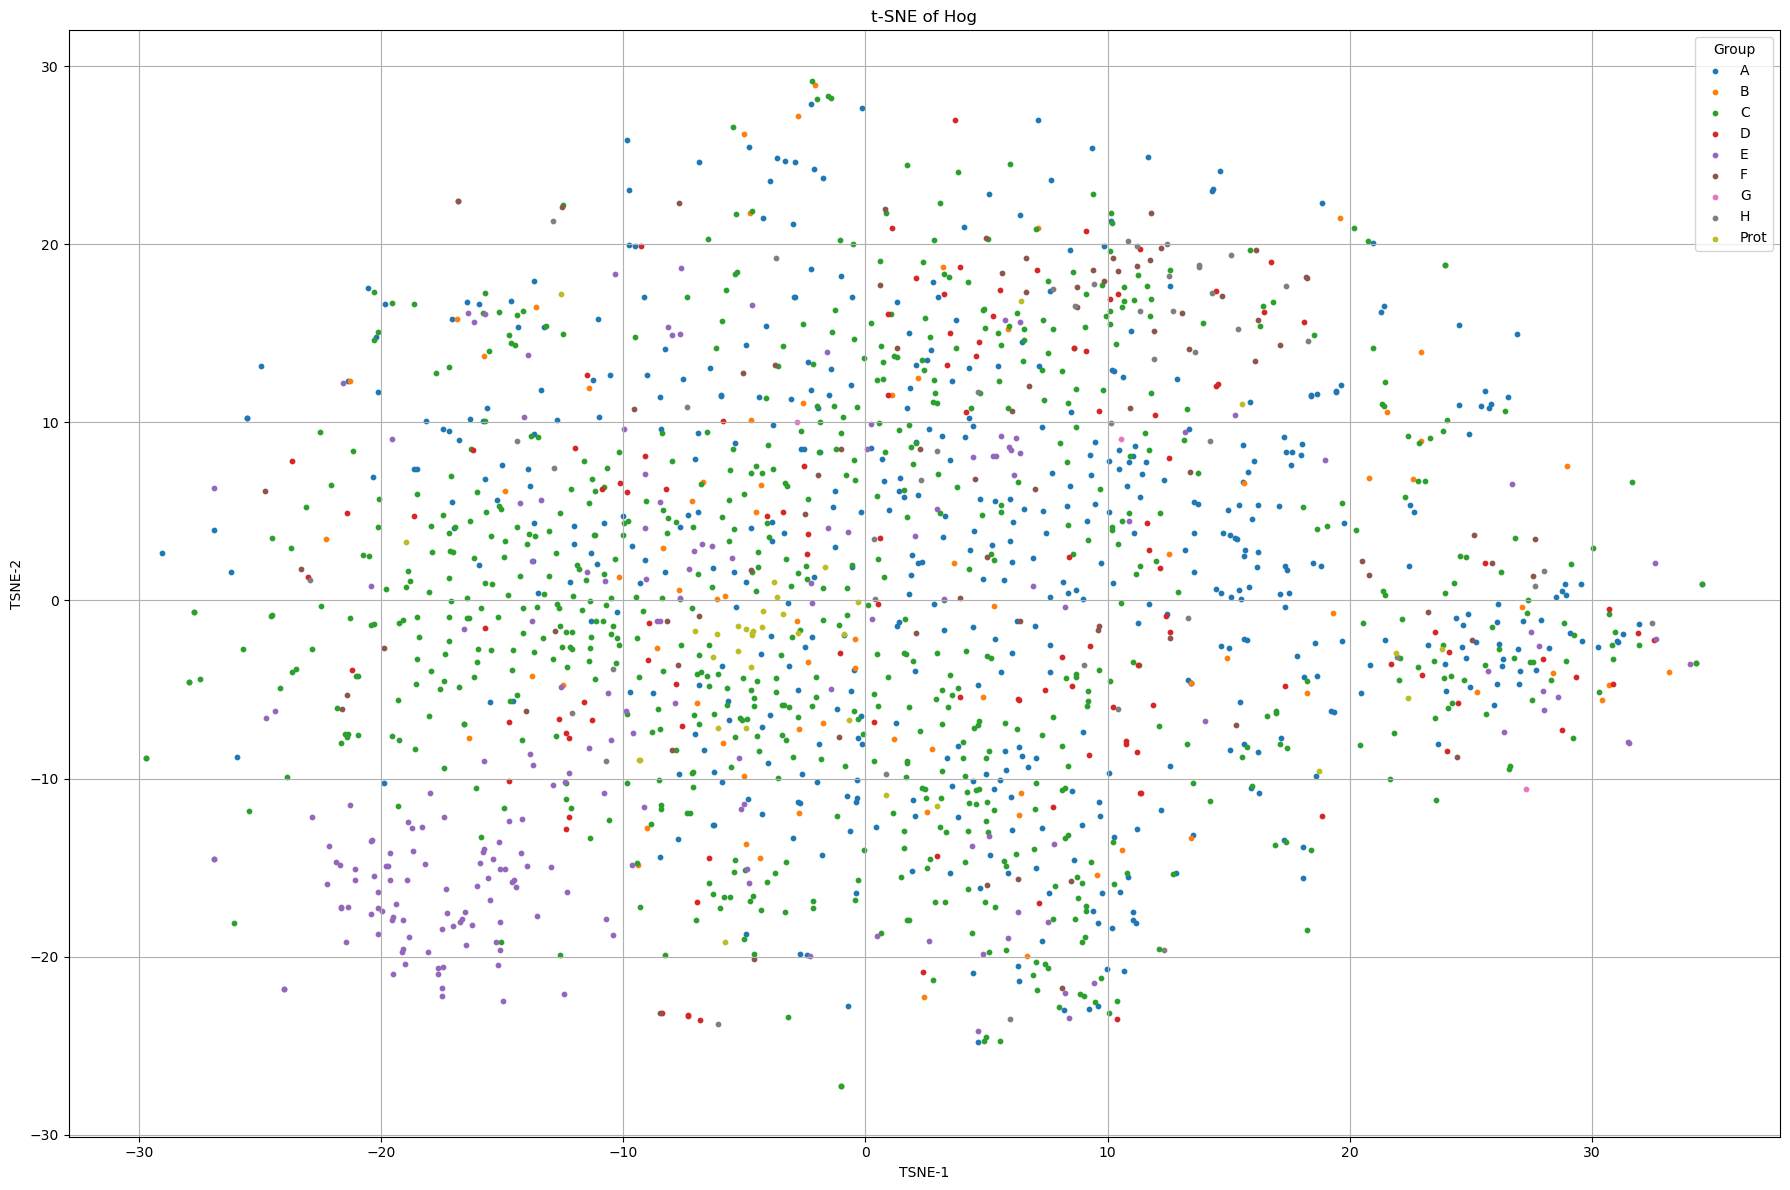

In [16]:
unique_labels = sorted(set(labels))
label_to_color = {label: plt.cm.tab10(i % 10) for i, label in enumerate(unique_labels)}
colors = [label_to_color[label] for label in labels]

# 6. Plotting
plt.figure(figsize=(18, 12))
for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], s=10, label=label, color=label_to_color[label])
#    for i in idxs:
#        if image_input_path[i].split("/")[3] == "Prot":
#            filename = os.path.basename(image_input_path[i])
#            plt.annotate(filename, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=15, alpha=0.6, color = "black")
plt.title("t-SNE of Hog")
plt.legend(title="Group")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.tight_layout()
#plt.savefig("tSNE annotated new with prot after restart.png")
plt.show()

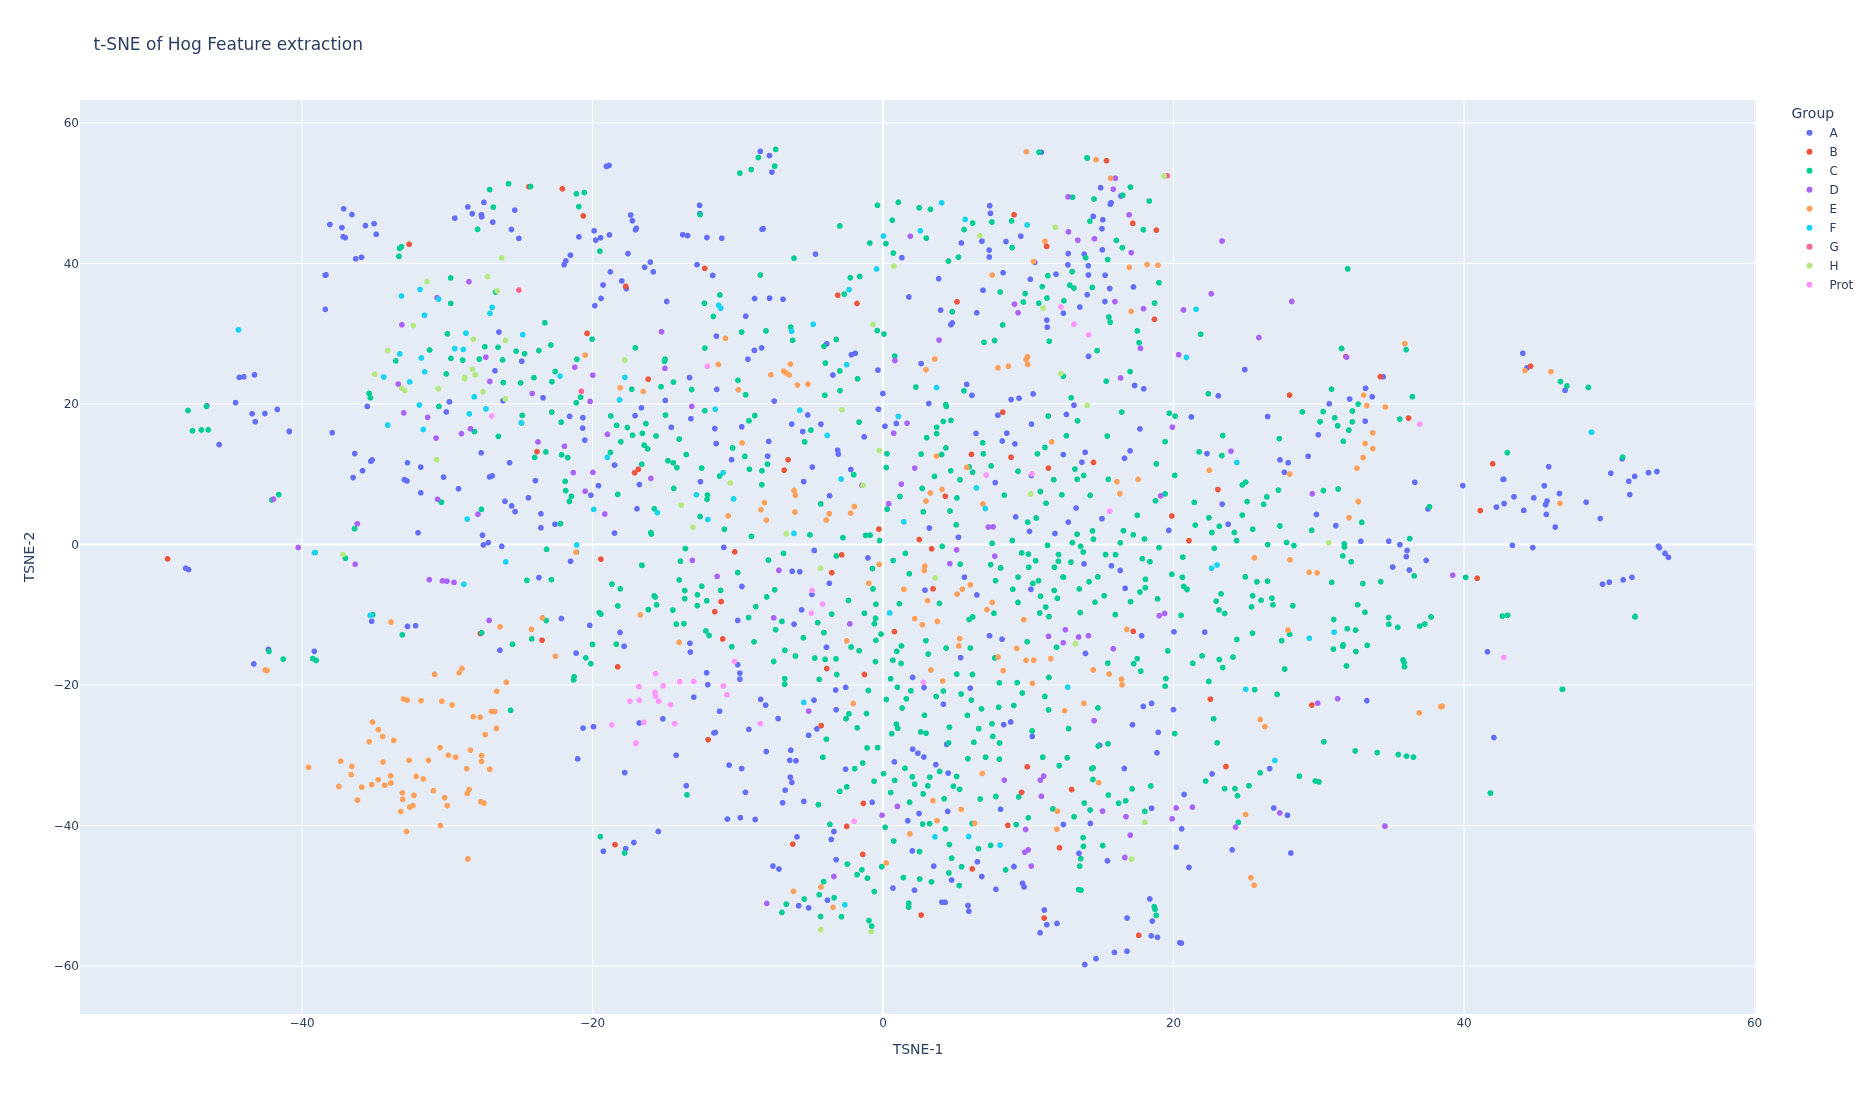

In [42]:
import plotly.express as px
import pandas as pd
import os

unique_labels = sorted(set(labels))  # Alphabetisch sortiert

# Daten vorbereiten
data = {
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "label": labels,
    "path": ["/".join(path.split("/")[-2:]) for path in image_input_path]
}

df = pd.DataFrame(data)

# Plotly-Scatterplot
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="label",
    hover_data=["path"],
    title="t-SNE of Hog Feature extraction",
    labels={"x": "TSNE-1", "y": "TSNE-2", "label": "Group"},
    category_orders={"label": unique_labels}  # <- hier den korrekten Spaltennamen angeben
)

fig.update_layout(
    legend_title_text="Group",
    width=1920,
    height=1080
)

#fig.write_html("t-SNE.html")
fig.show()



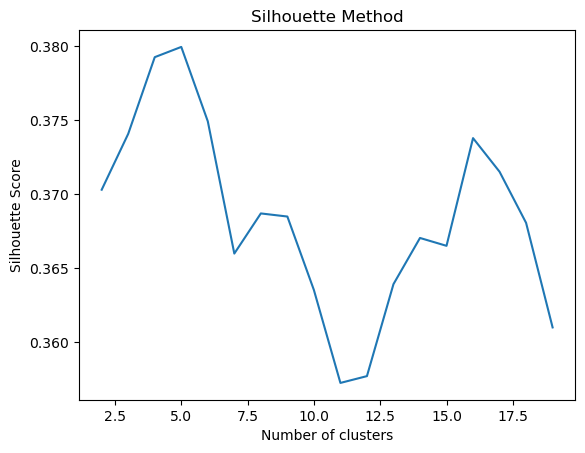

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Assuming data is a 2D numpy array or a pandas DataFrame


silhouette_scores = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_tsne)
    score = silhouette_score(X_tsne, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 20), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

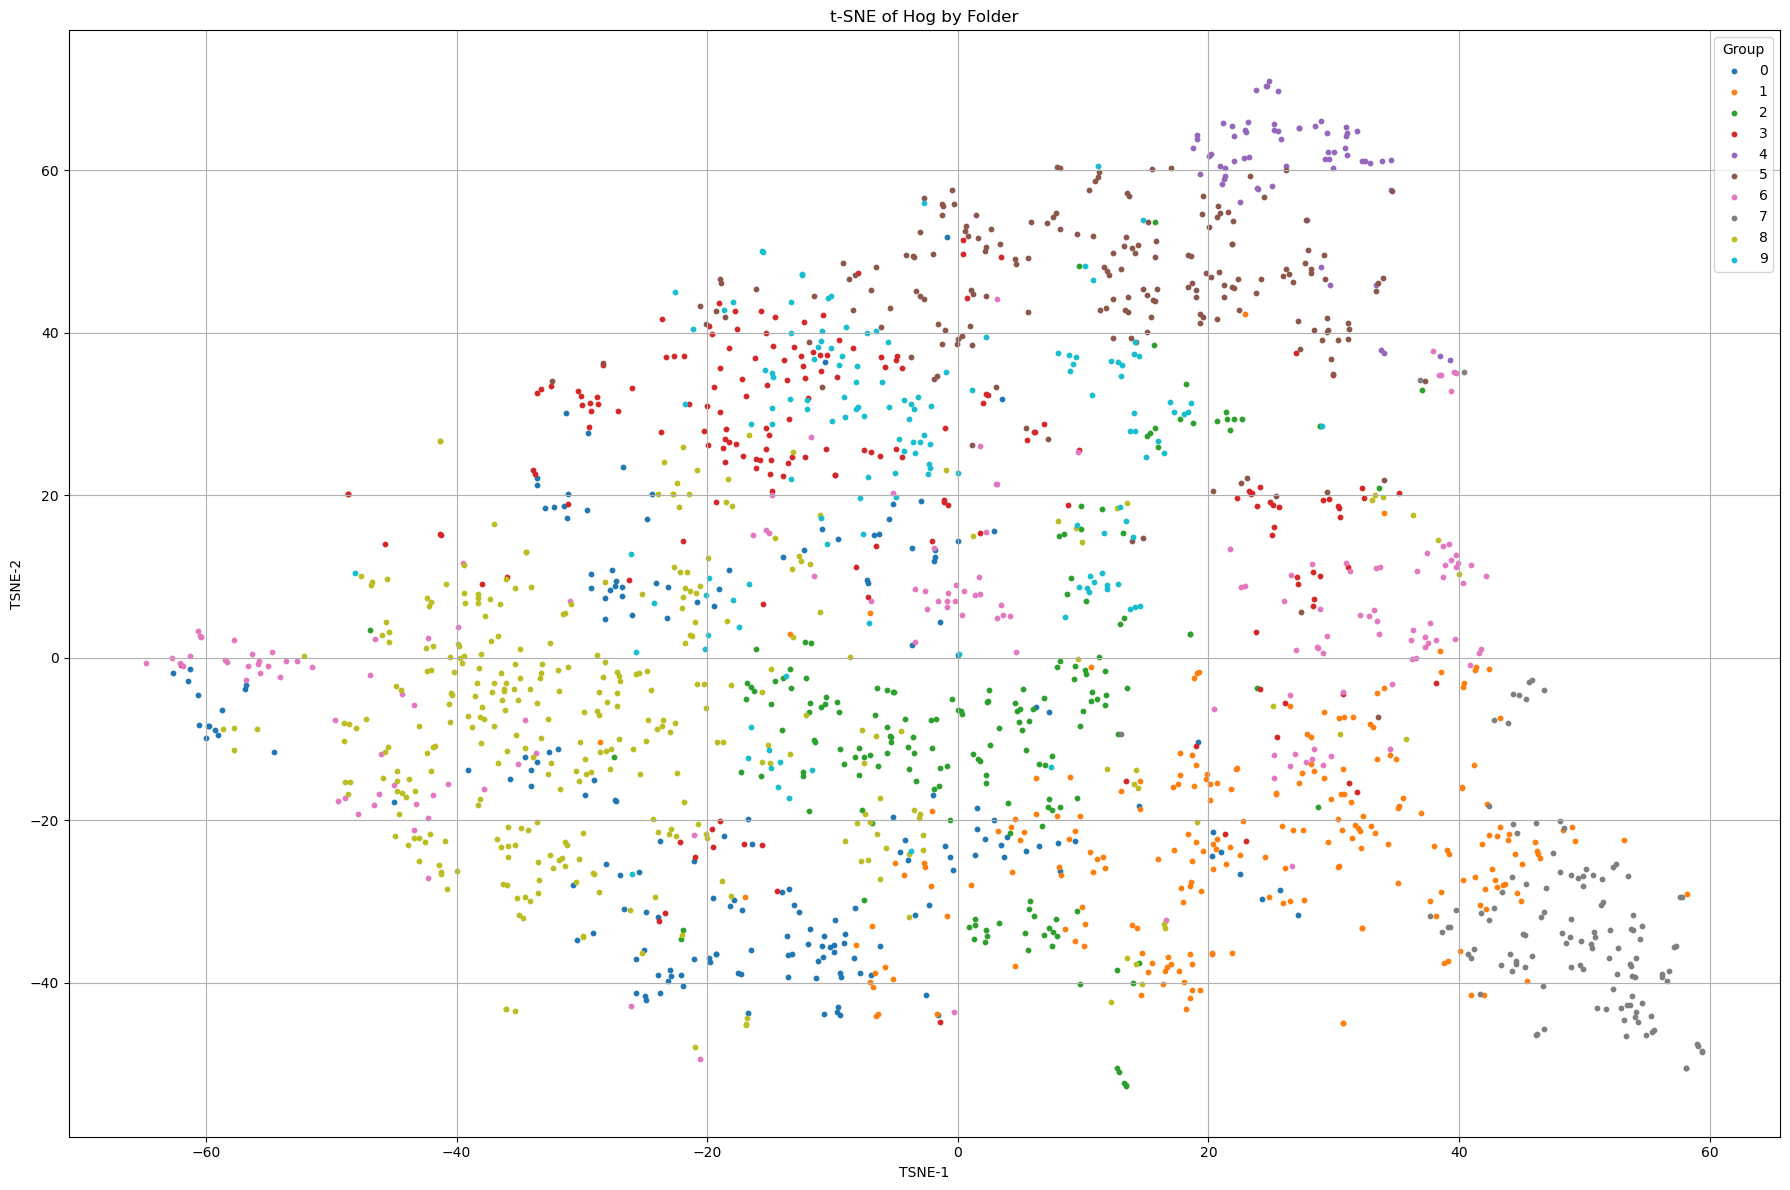

<Figure size 640x480 with 0 Axes>

In [23]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(features)

# 2D-Reduktion (t-SNE oder UMAP)
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(features)

# Visualisierung
labels = labels[:X_2d.shape[0]]
# 5. Color mapping
unique_labels = sorted(set(labels))
label_to_color = {label: plt.cm.tab10(i % 10) for i, label in enumerate(unique_labels)}
colors = [label_to_color[label] for label in labels]

# 6. Plotting
plt.figure(figsize=(18, 12))
for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], s=10, label=label, color=label_to_color[label])
#   for i in idxs:
#        if image_input_path[i] == '../bueschelquinare_preprocessed/obverse/Prot/3444_a_cropped_graymasked.png':
#            filename = os.path.basename(image_input_path[i])
#            plt.annotate(filename, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=15, alpha=0.6)

plt.title("t-SNE of Hog by Folder")
plt.legend(title="Group")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("TSNE.png")

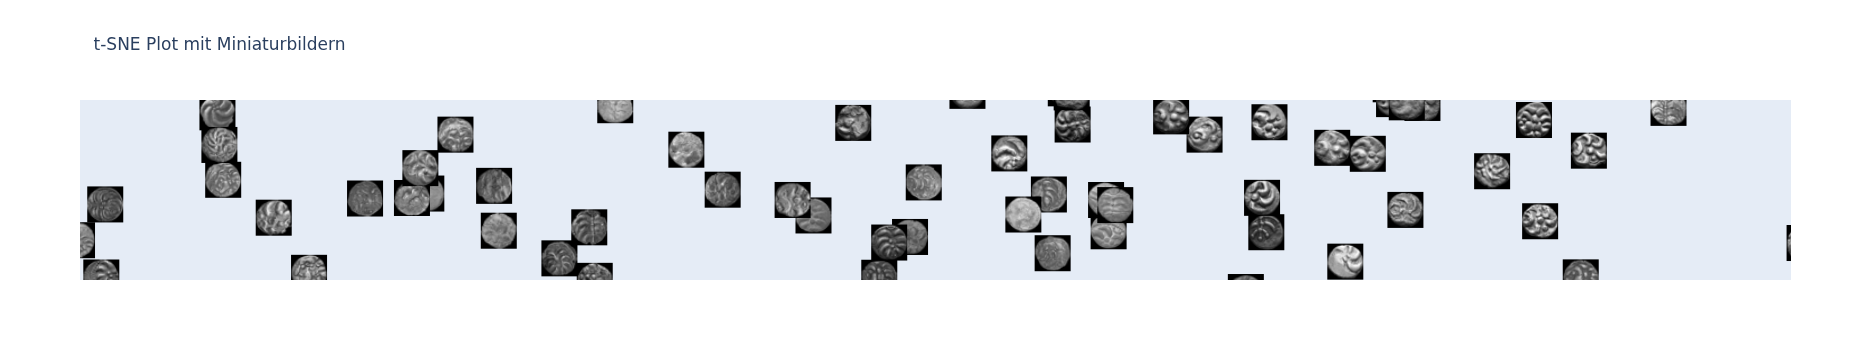

In [22]:
import plotly.graph_objects as go
from PIL import Image
import base64
from io import BytesIO

data = []

for i in range(len(X_2d)):
    img = Image.open(image_input_path[i]).convert("RGB")
    img.thumbnail((32, 32))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    img_b64 = base64.b64encode(buffer.getvalue()).decode()

    data.append(dict(
        x=X_2d[i, 0],
        y=X_2d[i, 1],
        source=f'data:image/png;base64,{img_b64}',
        label=labels[i]
    ))

fig = go.Figure()

for d in data:
    fig.add_layout_image(
        dict(
            source=d["source"],
            x=d["x"],
            y=d["y"],
            xref="x",
            yref="y",
            sizex=1,  # ggf. anpassen je nach Plotgröße
            sizey=1,
            xanchor="center",
            yanchor="middle",
            layer="above"
        )
    )

fig.update_layout(
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    title="t-SNE Plot mit Miniaturbildern"
)

fig.show()
fig.write_html("tsne_plot.html")



In [28]:
print(len(feature_vector[1]))


26244


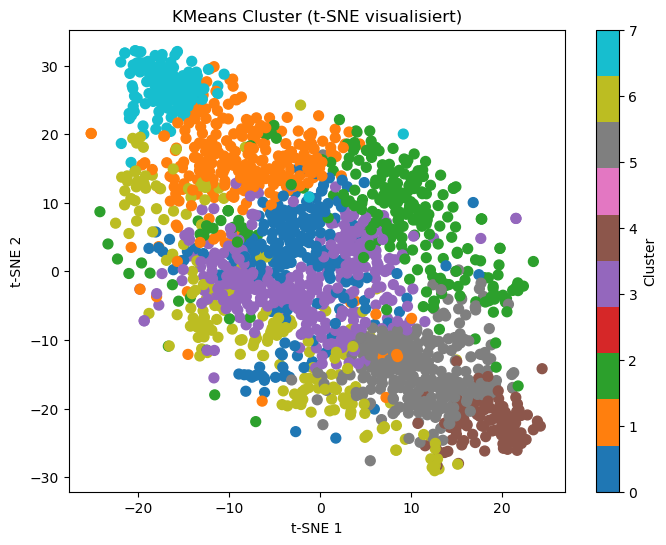

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
# alternativ: from umap import UMAP

# Features (z. B. aus CNN), shape: (n_samples, n_features)
X = np.array(feature_vector)

# Clustering
kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(X)

# 2D-Reduktion (t-SNE oder UMAP)
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

# Visualisierung
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=50)
plt.title("KMeans Cluster (t-SNE visualisiert)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster")
plt.show()


In [38]:
import pandas as pd
import json
data = {
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "label": labels,
    
}


# Farbzuordnung nach Label erzeugen (wie Plotly)
unique_labels = sorted(set(df["label"]))
colors = plt.cm.tab10.colors  # bis zu 10 Klassen, alternativ z.B. 'Set3', 'Accent', 'Dark2'
label_color_map = {label: f"rgb({int(r*255)},{int(g*255)},{int(b*255)})"
                   for label, (r, g, b) in zip(unique_labels, colors)}




# Als JSON exportieren für JS

df = pd.DataFrame(data)
df['path'] = image_input_path

data_json_str = json.dumps(data_json)
label_color_map_str = json.dumps(label_color_map)

In [39]:
html = f"""
<!DOCTYPE html>
<html lang="de">
<head>
  <meta charset="UTF-8">
  <title>t-SNE Scatterplot mit Bildern</title>
  <script src="https://d3js.org/d3.v7.min.js"></script>
  <style>
    .tooltip {{
      position: absolute;
      display: none;
      border: 1px solid #ccc;
      background: white;
      padding: 5px;
      pointer-events: none;
    }}
    .tooltip img {{
      width: 150px;
      height: auto;
    }}
    .legend {{
      font-size: 14px;
    }}
    .legend rect {{
      stroke-width: 1;
      stroke: black;
    }}
  </style>
</head>
<body>
<div id="scatterplot"></div>
<div class="tooltip" id="tooltip"></div>

<script>
  const data = {data_json_str};
  const labelColorMap = {label_color_map_str};

  const margin = {{top: 20, right: 30, bottom: 50, left: 50}},
        width = 1000 - margin.left - margin.right,
        height = 800 - margin.top - margin.bottom;

  const svg = d3.select("#scatterplot")
    .append("svg")
      .attr("width", width + margin.left + margin.right)
      .attr("height", height + margin.top + margin.bottom)
    .append("g")
      .attr("transform", `translate(${{margin.left}},${{margin.top}})`);

  const xExtent = d3.extent(data, d => d.x);
  const yExtent = d3.extent(data, d => d.y);

  const x = d3.scaleLinear().domain(xExtent).range([0, width]);
  const y = d3.scaleLinear().domain(yExtent).range([height, 0]);

  svg.append("g")
    .attr("transform", `translate(0, ${{height}})`)
    .call(d3.axisBottom(x));

  svg.append("g")
    .call(d3.axisLeft(y));

  const tooltip = d3.select("#tooltip");

  svg.selectAll("circle")
    .data(data)
    .enter()
    .append("circle")
      .attr("cx", d => x(d.x))
      .attr("cy", d => y(d.y))
      .attr("r", 4)
      .style("fill", d => labelColorMap[d.label] || "gray")
      .on("mouseover", (event, d) => {{
        tooltip
          .style("left", (event.pageX + 10) + "px")
          .style("top", (event.pageY - 30) + "px")
          .style("display", "block")
          .html(`<img src="${{d.path}}" alt="Bild">`);
      }})
      .on("mousemove", (event) => {{
        tooltip
          .style("left", (event.pageX + 10) + "px")
          .style("top", (event.pageY - 30) + "px");
      }})
      .on("mouseout", () => {{
        tooltip.style("display", "none");
      }});

  // Legend
  const legend = svg.append("g")
    .attr("class", "legend")
    .attr("transform", `translate(${{width + 20}}, 0)`);

  const labels = Object.keys(labelColorMap);
  labels.forEach((label, i) => {{
    legend.append("rect")
      .attr("x", 0)
      .attr("y", i * 20)
      .attr("width", 12)
      .attr("height", 12)
      .style("fill", labelColorMap[label]);

    legend.append("text")
      .attr("x", 20)
      .attr("y", i * 20 + 10)
      .text(label)
      .attr("alignment-baseline", "middle");
  }});
</script>
</body>
</html>
"""


In [13]:
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category20, turbo
from PIL import Image
from io import BytesIO
import base64
import os
import numpy as np

# Convert image to base64 thumbnail
def image_to_base64(path):
    img = Image.open(path).convert("RGB")
    img.thumbnail((128, 128))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode()

# Inputs
# - image_paths: list of paths to coin images
# - labels: list of folder labels (e.g. os.path.basename(os.path.dirname(path)))
# - embedding: np.array of shape (n_samples, 2), from UMAP

# Generate thumbnails
thumbnails = [f"data:image/png;base64,{image_to_base64(p)}" for p in image_input_paths]

# Unique labels & distinct color palette
unique_labels = sorted(set(labels))
n_labels = len(unique_labels)

# Use turbo or Category20 palette with fallback
palette = turbo(n_labels) if n_labels > 20 else Category20[n_labels]
label_to_color = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

# Output file
output_file("umap_by_label_with_legend.html")

# Initialize plot
p = figure(title="UMAP of Coin Images Colored by Folder Label (With Legend)",
           tools="pan,wheel_zoom,reset,save",
           width=1000, height=800)

# Hover tool setup
hover = HoverTool(tooltips="""
    <div>
        <div><strong>@filename</strong> (@label)</div>
        <img src="@imgs" alt="image" style="width:64px;height:64px;" />
    </div>
""")
p.add_tools(hover)

# Plot one glyph per label for proper legend entries
for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    data = dict(
        x=X_tsne[idxs, 0],
        y=X_tsne[idxs, 1],
        imgs=[thumbnails[i] for i in idxs],
        filename=[os.path.basename(image_input_paths[i]) for i in idxs],
        label=[label] * len(idxs),
    )
    source = ColumnDataSource(data)
    p.scatter('x', 'y', size=10, source=source,
             fill_color=label_to_color[label],
             line_color=None, fill_alpha=0.7,
             legend_label=label)

# Style legend
p.legend.location = "top_right"
p.legend.click_policy = "hide"
p.legend.label_text_font_size = "10pt"

# Show it
#output_file("Coin_clip_tSNE.html")
#save(p)
#save(p)
show(p)

KeyError: 1